## Import

In [ ]:
import argparse
import time
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import numpy as np
import timm


## Parameter configuration

In [ ]:
class Args:
    data_root = "./data"
    batch_size = 32
    num_workers = 4
    epochs = 5          # must be <= 5
    lr = 5e-5
    weight_decay = 0.1
    model_name = "vit_small_patch16_224"
    out_dir = "./ckpt_vit_cifar100"
    seed = 42
    use_amp = True
    subset_ratio = 0.5  # 0 < r <= 1.0
    mode = "full"               # "full" or "linear"

args = Args()


## Random seed

In [ ]:
def set_seed(seed: int):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(args.seed)


## Dataloader

In [ ]:
def get_dataloaders(data_root, batch_size, num_workers,
                    subset_ratio=1.0, seed=42):

    mean = (0.5071, 0.4867, 0.4408)
    std = (0.2675, 0.2565, 0.2761)

    train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    train_set = datasets.CIFAR100(
        root=data_root, train=True, download=True, transform=train_transform
    )
    test_set = datasets.CIFAR100(
        root=data_root, train=False, download=True, transform=test_transform
    )

    if subset_ratio < 1.0:
        np.random.seed(seed)
        indices = np.random.permutation(len(train_set))
        k = int(len(train_set) * subset_ratio)
        train_set = Subset(train_set, indices[:k])
        print(f"Using subset: {k} samples ({subset_ratio*100:.1f}%)")

    train_loader = DataLoader(
        train_set, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )
    test_loader = DataLoader(
        test_set, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )

    return train_loader, test_loader


## Create model

In [ ]:
def create_model(model_name: str, num_classes: int = 100):
    return timm.create_model(
        model_name, pretrained=True, num_classes=num_classes
    )


def freeze_backbone_for_linear_probe(model):
    head_names = ["head", "fc", "classifier"]

    for p in model.parameters():
        p.requires_grad = False

    for name, p in model.named_parameters():
        if any(name.startswith(hn) for hn in head_names):
            p.requires_grad = True

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"[Linear Probe] Trainable params: {trainable}/{total} "
          f"({100*trainable/total:.4f}%)")


## Train and evaluate funciton

In [ ]:
def train_one_epoch(model, loader, criterion, optimizer,
                    device, epoch, scaler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    start = time.time()

    for i, (images, targets) in enumerate(loader):
        images = images.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)

    print(f"Train Epoch {epoch}: "
          f"Loss {running_loss/total:.4f}, "
          f"Acc {100*correct/total:.2f}%, "
          f"Time {(time.time()-start)/60:.2f} min")


In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)

    acc = 100 * correct / total
    print(f"Val: Loss {running_loss/total:.4f}, Acc {acc:.2f}%")
    return acc


## Run experiment with specific args

In [ ]:
import time
from pathlib import Path

def run_experiment(current_args):
    set_seed(current_args.seed)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"\n--- Running Experiment | LR={current_args.lr}, WD={current_args.weight_decay}, Subset={current_args.subset_ratio} ---")
    print("Device:", device)
    print("Mode:", current_args.mode)

    train_loader, val_loader = get_dataloaders(
        current_args.data_root,
        current_args.batch_size,
        current_args.num_workers,
        subset_ratio=current_args.subset_ratio,
        seed=current_args.seed,
    )

    model = create_model(current_args.model_name, num_classes=100).to(device)
    if current_args.mode == "linear":
      freeze_backbone_for_linear_probe(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=current_args.lr,
        weight_decay=current_args.weight_decay
    )

    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=current_args.epochs
    )

    scaler = torch.cuda.amp.GradScaler() if current_args.use_amp and device == "cuda" else None

    best_acc = 0.0

    start_time = time.time()
    for epoch in range(1, current_args.epochs + 1):
        train_one_epoch(
            model, train_loader, criterion,
            optimizer, device, epoch, scaler
        )
        val_acc = evaluate(model, val_loader, criterion, device)
        scheduler.step()

        if val_acc > best_acc:
            best_acc = val_acc

    total_time_sec = time.time() - start_time
    return best_acc, total_time_sec

Plot thr grid search

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_grid_heatmap(grid_results):
    lrs = sorted({r['params']['lr'] for r in grid_results})
    wds = sorted({r['params']['weight_decay'] for r in grid_results})

    acc = np.zeros((len(wds), len(lrs)))

    for r in grid_results:
        i = wds.index(r['params']['weight_decay'])
        j = lrs.index(r['params']['lr'])
        acc[i, j] = r['accuracy']

    plt.figure()
    plt.imshow(acc)
    plt.xticks(range(len(lrs)), [f"{lr:.0e}" for lr in lrs])
    plt.yticks(range(len(wds)), [str(wd) for wd in wds])
    plt.xlabel("Learning Rate")
    plt.ylabel("Weight Decay")
    plt.title("Grid Search Accuracy Heatmap")
    plt.colorbar(label="Validation Accuracy")
    plt.show()


## Full Fine-Tuning

### Grid Search

In [ ]:
from itertools import product
import copy
import time

print("Starting Grid Search...")

# Define parameter grid
param_grid = {
    "lr": [5e-5, 1e-4, 3e-4],
    "weight_decay": [0.0, 0.01, 0.1],
}

best_grid_acc = 0.0
best_grid_params = {}
grid_results = []

# Get all combinations of hyperparameters
keys, values = zip(*param_grid.items())

for p_values in product(*values):
    current_params = dict(zip(keys, p_values))

    # Create a new Args object for this experiment run to avoid modifying global args
    temp_args = copy.deepcopy(args)
    temp_args.subset_ratio = 0.5
    temp_args.epochs = 3

    for k, v in current_params.items():
        setattr(temp_args, k, v)

    # Run the experiment
    result = run_experiment(temp_args)

    current_acc = result[0]
    current_time = result[1]

    record = {
        'params': current_params,
        'accuracy': float(current_acc),
    }
    if current_time is not None:
        record['time_sec'] = float(current_time)

    grid_results.append(record)

    if current_acc > best_grid_acc:
        best_grid_acc = current_acc
        best_grid_params = current_params

print("\n--- Grid Search Results ---")
for res in grid_results:
    if 'time_sec' in res:
        print(f"Params: {res['params']}, Acc: {res['accuracy']:.2f}%, Time: {res['time_sec']:.1f}s")
    else:
        print(f"Params: {res['params']}, Accuracy: {res['accuracy']:.2f}%")

print("\n--- Best Grid Search Result ---")
print(f"Best Params: {best_grid_params}")
print(f"Best Accuracy: {best_grid_acc:.2f}%")

Starting Grid Search...

--- Running Experiment | LR=5e-05, WD=0.0, Subset=0.5 ---
Device: cuda
Mode: full
Using subset: 25000 samples (50.0%)


/tmp/ipython-input-1831048097.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if current_args.use_amp and device == "cuda" else None
/tmp/ipython-input-898826741.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Epoch 1: Loss 1.7229, Acc 58.91%, Time 0.47 min
Val: Loss 0.5738, Acc 83.37%
Train Epoch 2: Loss 0.8464, Acc 77.27%, Time 0.46 min
Val: Loss 0.4344, Acc 86.81%
Train Epoch 3: Loss 0.6379, Acc 82.94%, Time 0.48 min
Val: Loss 0.3786, Acc 88.74%

--- Running Experiment | LR=5e-05, WD=0.01, Subset=0.5 ---
Device: cuda
Mode: full
Using subset: 25000 samples (50.0%)
Train Epoch 1: Loss 1.7268, Acc 58.89%, Time 0.47 min
Val: Loss 0.5519, Acc 83.92%
Train Epoch 2: Loss 0.8448, Acc 77.46%, Time 0.45 min
Val: Loss 0.4483, Acc 86.57%
Train Epoch 3: Loss 0.6392, Acc 82.90%, Time 0.47 min
Val: Loss 0.3800, Acc 88.64%

--- Running Experiment | LR=5e-05, WD=0.1, Subset=0.5 ---
Device: cuda
Mode: full
Using subset: 25000 samples (50.0%)
Train Epoch 1: Loss 1.7227, Acc 58.98%, Time 0.46 min
Val: Loss 0.5499, Acc 84.19%
Train Epoch 2: Loss 0.8398, Acc 77.43%, Time 0.46 min
Val: Loss 0.4440, Acc 86.76%
Train Epoch 3: Loss 0.6351, Acc 82.88%, Time 0.47 min
Val: Loss 0.3758, Acc 88.67%

--- Running E

Show the result in graph

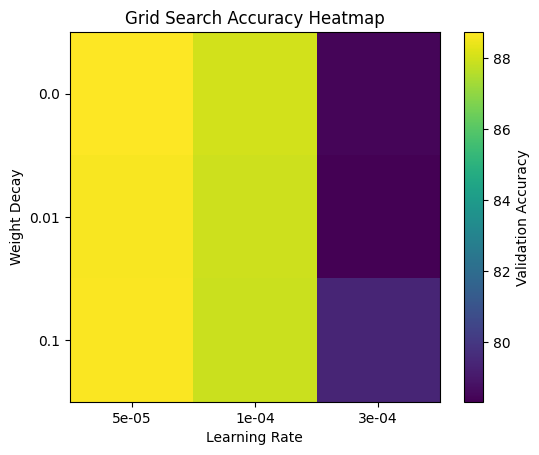

In [ ]:
plot_grid_heatmap(grid_results)

Set params:

In [ ]:
for k, v in best_grid_params.items():
    setattr(args, k, v)

In [ ]:
subset_list = [0.1, 0.5, 1.0]
results = []

for sr in subset_list:
    temp_args = copy.deepcopy(args)
    temp_args.subset_ratio = sr
    temp_args.epochs = 5

    best_acc, t_sec = run_experiment(temp_args)

    results.append({
        "subset_ratio": sr,
        "best_acc": best_acc,
        "time_sec": t_sec,
        "time_min": t_sec / 60.0
    })

print("\n--- Subset Scaling Results ---")
for r in results:
    print(f"subset={int(r['subset_ratio']*100):>3}% | best_acc={r['best_acc']:.2f}% | "
          f"time={r['time_min']:.2f} min ({r['time_sec']:.1f} s)")



--- Running Experiment | LR=5e-05, WD=0.0, Subset=0.1 ---
Device: cuda
Mode: full
Using subset: 5000 samples (10.0%)


/tmp/ipython-input-1831048097.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if current_args.use_amp and device == "cuda" else None
/tmp/ipython-input-898826741.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Epoch 1: Loss 3.4842, Acc 24.42%, Time 0.10 min
Val: Loss 1.7100, Acc 61.27%
Train Epoch 2: Loss 1.5128, Acc 64.32%, Time 0.10 min
Val: Loss 0.9265, Acc 77.33%
Train Epoch 3: Loss 0.9865, Acc 75.52%, Time 0.10 min
Val: Loss 0.7344, Acc 80.83%
Train Epoch 4: Loss 0.7907, Acc 80.88%, Time 0.10 min
Val: Loss 0.6582, Acc 82.66%
Train Epoch 5: Loss 0.6526, Acc 84.54%, Time 0.10 min
Val: Loss 0.6275, Acc 83.52%

--- Running Experiment | LR=5e-05, WD=0.0, Subset=0.5 ---
Device: cuda
Mode: full
Using subset: 25000 samples (50.0%)
Train Epoch 1: Loss 1.7229, Acc 58.91%, Time 0.47 min
Val: Loss 0.5738, Acc 83.37%
Train Epoch 2: Loss 0.8766, Acc 76.50%, Time 0.47 min
Val: Loss 0.4557, Acc 86.56%
Train Epoch 3: Loss 0.6967, Acc 81.09%, Time 0.47 min
Val: Loss 0.4063, Acc 87.42%
Train Epoch 4: Loss 0.5808, Acc 84.18%, Time 0.45 min
Val: Loss 0.3612, Acc 89.29%
Train Epoch 5: Loss 0.4943, Acc 86.65%, Time 0.46 min
Val: Loss 0.3451, Acc 89.61%

--- Running Experiment | LR=5e-05, WD=0.0, Subset=

## Linear Probing

### Grid Search

Set mode

In [ ]:
args.mode="linear"

In [ ]:
print("Starting Grid Search...")

# Define parameter grid
param_grid = {
    "lr": [1e-4, 3e-4, 1e-3],
    "weight_decay": [0.0, 0.01, 0.3],
}

best_grid_acc = 0.0
best_grid_params = {}
grid_results = []

# Get all combinations of hyperparameters
keys, values = zip(*param_grid.items())

for p_values in product(*values):
    current_params = dict(zip(keys, p_values))

    # Create a new Args object for this experiment run to avoid modifying global args
    temp_args = copy.deepcopy(args)
    temp_args.subset_ratio = 0.5
    temp_args.epochs = 3

    for k, v in current_params.items():
        setattr(temp_args, k, v)

    # Run the experiment
    result = run_experiment(temp_args)

    current_acc = result[0]
    current_time = result[1]

    record = {
        'params': current_params,
        'accuracy': float(current_acc),
    }
    if current_time is not None:
        record['time_sec'] = float(current_time)

    grid_results.append(record)

    if current_acc > best_grid_acc:
        best_grid_acc = current_acc
        best_grid_params = current_params

print("\n--- Grid Search Results ---")
for res in grid_results:
    if 'time_sec' in res:
        print(f"Params: {res['params']}, Acc: {res['accuracy']:.2f}%, Time: {res['time_sec']:.1f}s")
    else:
        print(f"Params: {res['params']}, Accuracy: {res['accuracy']:.2f}%")

print("\n--- Best Grid Search Result ---")
print(f"Best Params: {best_grid_params}")
print(f"Best Accuracy: {best_grid_acc:.2f}%")

Starting Grid Search...

--- Running Experiment | LR=0.0001, WD=0.0, Subset=0.5 ---
Device: cuda
Mode: linear
Using subset: 25000 samples (50.0%)
[Linear Probe] Trainable params: 38500/21704164 (0.1774%)


/tmp/ipython-input-1831048097.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if current_args.use_amp and device == "cuda" else None
/tmp/ipython-input-898826741.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Epoch 1: Loss 3.1443, Acc 33.76%, Time 0.32 min
Val: Loss 1.6444, Acc 65.67%
Train Epoch 2: Loss 1.7800, Acc 59.47%, Time 0.32 min
Val: Loss 1.1638, Acc 72.40%
Train Epoch 3: Loss 1.5479, Acc 62.94%, Time 0.31 min
Val: Loss 1.0860, Acc 73.34%

--- Running Experiment | LR=0.0001, WD=0.01, Subset=0.5 ---
Device: cuda
Mode: linear
Using subset: 25000 samples (50.0%)
[Linear Probe] Trainable params: 38500/21704164 (0.1774%)
Train Epoch 1: Loss 3.1444, Acc 33.76%, Time 0.32 min
Val: Loss 1.6447, Acc 65.67%
Train Epoch 2: Loss 1.7803, Acc 59.48%, Time 0.32 min
Val: Loss 1.1642, Acc 72.42%
Train Epoch 3: Loss 1.5482, Acc 62.94%, Time 0.32 min
Val: Loss 1.0864, Acc 73.33%

--- Running Experiment | LR=0.0001, WD=0.3, Subset=0.5 ---
Device: cuda
Mode: linear
Using subset: 25000 samples (50.0%)
[Linear Probe] Trainable params: 38500/21704164 (0.1774%)
Train Epoch 1: Loss 3.1475, Acc 33.84%, Time 0.32 min
Val: Loss 1.6533, Acc 65.77%
Train Epoch 2: Loss 1.7896, Acc 59.64%, Time 0.32 min
Val:

Plot the result

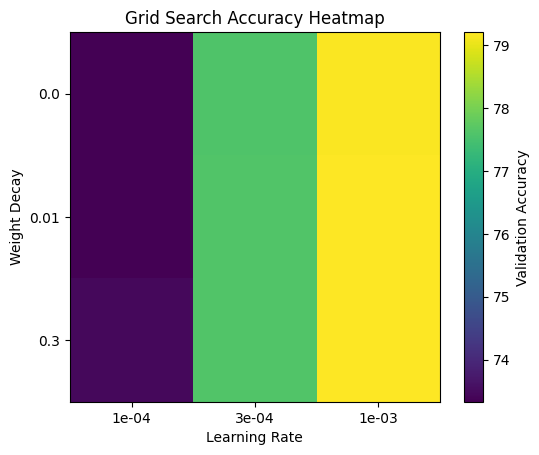

In [ ]:
plot_grid_heatmap(grid_results)

Set params

In [ ]:
for k, v in best_grid_params.items():
    setattr(args, k, v)

Do experiment

In [27]:
subset_list = [0.1, 0.5, 1.0]
results = []

for sr in subset_list:
    temp_args = copy.deepcopy(args)
    temp_args.subset_ratio = sr
    temp_args.epochs = 5

    best_acc, t_sec = run_experiment(temp_args)

    results.append({
        "subset_ratio": sr,
        "best_acc": best_acc,
        "time_sec": t_sec,
        "time_min": t_sec / 60.0
    })

print("\n--- Subset Scaling Results ---")
for r in results:
    print(f"subset={int(r['subset_ratio']*100):>3}% | best_acc={r['best_acc']:.2f}% | "
          f"time={r['time_min']:.2f} min ({r['time_sec']:.1f} s)")



--- Running Experiment | LR=0.001, WD=0.01, Subset=0.1 ---
Device: cuda
Mode: linear
Using subset: 5000 samples (10.0%)
[Linear Probe] Trainable params: 38500/21704164 (0.1774%)


/tmp/ipython-input-1831048097.py:36: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if current_args.use_amp and device == "cuda" else None
/tmp/ipython-input-898826741.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Train Epoch 1: Loss 2.6246, Acc 41.38%, Time 0.07 min
Val: Loss 1.1749, Acc 69.62%
Train Epoch 2: Loss 1.3754, Acc 63.92%, Time 0.07 min
Val: Loss 0.9961, Acc 72.03%
Train Epoch 3: Loss 1.1333, Acc 69.90%, Time 0.07 min
Val: Loss 0.9186, Acc 73.70%
Train Epoch 4: Loss 1.0465, Acc 72.50%, Time 0.07 min
Val: Loss 0.8859, Acc 74.76%
Train Epoch 5: Loss 0.9529, Acc 74.44%, Time 0.07 min
Val: Loss 0.8692, Acc 75.29%

--- Running Experiment | LR=0.001, WD=0.01, Subset=0.5 ---
Device: cuda
Mode: linear
Using subset: 25000 samples (50.0%)
[Linear Probe] Trainable params: 38500/21704164 (0.1774%)
Train Epoch 1: Loss 1.6611, Acc 57.70%, Time 0.31 min
Val: Loss 0.8261, Acc 76.13%
Train Epoch 2: Loss 1.1884, Acc 67.48%, Time 0.32 min
Val: Loss 0.7644, Acc 78.01%
Train Epoch 3: Loss 1.1027, Acc 69.79%, Time 0.32 min
Val: Loss 0.7327, Acc 78.72%
Train Epoch 4: Loss 1.0166, Acc 71.92%, Time 0.31 min
Val: Loss 0.6909, Acc 79.70%
Train Epoch 5: Loss 0.9561, Acc 73.33%, Time 0.32 min
Val: Loss 0.6774, A